In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Quantile and bucket analysis

In [2]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
factor = pd.cut(frame.data1, 4)
factor[:10]

0    (0.0745, 1.679]
1    (-1.53, 0.0745]
2    (-1.53, 0.0745]
3    (-1.53, 0.0745]
4     (1.679, 3.284]
5    (0.0745, 1.679]
6    (-1.53, 0.0745]
7    (-1.53, 0.0745]
8    (-1.53, 0.0745]
9    (0.0745, 1.679]
Name: data1, dtype: category
Categories (4, object): [(-3.142, -1.53] < (-1.53, 0.0745] < (0.0745, 1.679] < (1.679, 3.284]]

In [3]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.142, -1.53]",56.0,1.755423,-0.043593,-2.616105
"(-1.53, 0.0745]",477.0,3.291334,-0.047229,-3.429891
"(0.0745, 1.679]",419.0,2.502201,-0.005529,-2.895748
"(1.679, 3.284]",48.0,2.242241,0.063398,-2.087416


In [4]:
grouping = pd.qcut(frame.data1, 10, labels=False)

grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,1.755423,-0.043725,-2.616105
1,100.0,2.928873,0.088564,-1.964032
2,100.0,2.444503,-0.134126,-3.429891
3,100.0,2.280154,-0.025908,-2.658135
4,100.0,3.291334,-0.083880,-2.053819
5,100.0,2.424807,-0.067503,-2.527094
6,100.0,2.502201,-0.007038,-2.348952
7,100.0,2.024848,-0.013882,-2.555263
8,100.0,2.280538,0.026527,-2.895748


## Example: Filling missing values with group-specific values

In [5]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1    0.177312
2         NaN
3   -0.815817
4         NaN
5    1.319567
dtype: float64

In [6]:
s.fillna(s.mean())

0    0.227021
1    0.177312
2    0.227021
3   -0.815817
4    0.227021
5    1.319567
dtype: float64

In [7]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -0.166692
New York     -0.327077
Vermont            NaN
Florida       0.588951
Oregon       -0.425951
Nevada             NaN
California    1.268341
Idaho              NaN
dtype: float64

In [8]:
data.groupby(group_key).mean()

East    0.031727
West    0.421195
dtype: float64

In [9]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.166692
New York     -0.327077
Vermont       0.031727
Florida       0.588951
Oregon       -0.425951
Nevada        0.421195
California    1.268341
Idaho         0.421195
dtype: float64

In [10]:
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby(group_key).apply(fill_func)

Ohio         -0.166692
New York     -0.327077
Vermont       0.500000
Florida       0.588951
Oregon       -0.425951
Nevada       -1.000000
California    1.268341
Idaho        -1.000000
dtype: float64

## Example: Random sampling and permutation

In [13]:
suits = ['H', 'S', 'C', 'D']
card_val = ([i for i in range(1, 11)] + [10] * 3) * 4
base_names = ['A'] + [i for i in range(2, 11)] + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [14]:
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])
draw(deck)

JD    10
9D     9
8C     8
7H     7
QS    10
dtype: int64

In [15]:
get_suit = lambda card: card[-1]
deck.groupby(get_suit).apply(draw, n=2)

C  5C    5
   3C    3
D  8D    8
   7D    7
H  4H    4
   5H    5
S  7S    7
   8S    8
dtype: int64

In [16]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

JC     10
2C      2
6D      6
8D      8
10H    10
JH     10
7S      7
9S      9
dtype: int64

## Example: Group weighted average and correlation

In [17]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

,category,data,weights
0,a,0.232154,0.523259
1,a,-1.642629,0.720095
2,a,1.688881,0.693117
3,a,0.175747,0.430776
4,b,0.181601,0.874108
5,b,1.168295,0.712755
6,b,0.030540,0.542980
7,b,0.287650,0.367464


In [18]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.078119
b    0.445973
dtype: float64

In [19]:
close_px = pd.read_csv('stock_px.csv', parse_dates=True, index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [20]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


In [21]:
rets = close_px.pct_change().dropna()
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [22]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

## Example: Group-wise linear regression

In [23]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


# Pivot tables and Cross-tabulation

In [25]:
tips = pd.read_csv('tips.csv')
tips.pivot_table(index=['sex', 'smoker'])

size       tip  total_bill
sex    smoker                                
Female No      2.592593  2.773519   18.105185
       Yes     2.242424  2.931515   17.977879
Male   No      2.711340  3.113402   19.791237
       Yes     2.500000  3.051167   22.284500

In [26]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker')

size          
smoker             No       Yes
sex    day                     
Female Fri   2.500000  2.000000
       Sat   2.307692  2.200000
       Sun   3.071429  2.500000
       Thur  2.480000  2.428571
Male   Fri   2.000000  2.125000
       Sat   2.656250  2.629630
       Sun   2.883721  2.600000
       Thur  2.500000  2.300000

In [27]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker', margins=True)

KeyError: "['tip_pct'] not in index"

In [28]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

KeyError: "['tip_pct'] not in index"

In [29]:
tips.pivot_table('size', index=['time', 'sex', 'smoker'],
                 columns='day', aggfunc='sum', fill_value=0)


day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

## Cross-tabulations: crosstab

In [30]:
from StringIO import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

ModuleNotFoundError: No module named 'StringIO'

# Example: 2012 Federal Election Commission Database

In [31]:
fec = pd.read_csv('P00000001-ALL.csv')
fec.info()

/Users/alexkirnas/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [32]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [33]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [34]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

In [35]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [36]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [37]:
fec['party'] = fec.cand_nm.map(parties)

In [38]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [39]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [40]:
fec = fec[fec.contb_receipt_amt > 0]

In [41]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

## Donation statistics by occupation and employer

In [42]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [43]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [44]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [45]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')

In [46]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


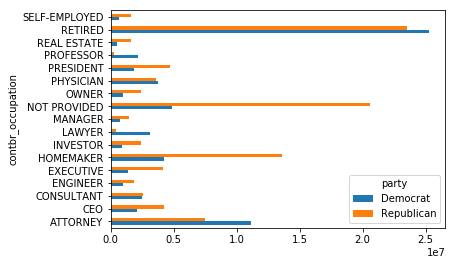

In [48]:
%matplotlib inline
over_2mm.plot(kind='barh')

In [55]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    return totals.order(ascending=False)[-n:]

In [56]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

/Users/alexkirnas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_occupation                     
Obama, Barack  COMPUTER ASSISTANT                        3.0
               SPRINKLER FITTER FIRE PROTECTION SPECI    3.0
               ADMINISTRATION/INSTRUCTOR                 3.0
               LEAD UI/UX DEVELOPER                      3.0
               POLICY/ LAWYER                            3.0
               LAN/WAN ANALYST                           3.0
               SR MGR                                    3.0
Romney, Mitt   MD - UROLOGIST                            5.0
               DISTRICT REPRESENTATIVE                   5.0
               INDEPENDENT PROFESSIONAL                  3.0
               REMODELER & SEMI RETIRED                  3.0
               AFFORDABLE REAL ESTATE DEVELOPER          3.0
               IFC CONTRACTING SOLUTIONS                 3.0
               3RD GENERATION FAMILY BUSINESS OWNER      3.0
Name: contb_receipt_amt, dtype: float64

In [57]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

/Users/alexkirnas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_employer                   
Obama, Barack  SOLIYA                                3.0
               CARR ENTERPRISES                      3.0
               PENN STATE DICKINSON SCHOOL OF LAW    3.0
               CADUCEUS OCCUPATIONAL MEDICINE        3.0
               N.A.                                  3.0
               REAL ENERGY CONSULTING SERVICES       3.0
               JPDSYSTEMS, LLC                       3.0
               CASS REGIONAL MED. CENTER             2.5
               ARCON CORP                            2.0
               THE VICTORIA GROUP, INC.              2.0
Romney, Mitt   EASTHAM CAPITAL                       5.0
               GREGORY GALLIVAN                      5.0
               DIRECT LENDERS LLC                    5.0
               LOUGH INVESTMENT ADVISORY LLC         4.0
               WATERWORKS INDUSRTIES                 3.0
               WILL MERRIFIELD                       3.0
               HONOLD COMMUNICTAIONS  

## Bucketing donation amounts

In [58]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

In [59]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [60]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [61]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


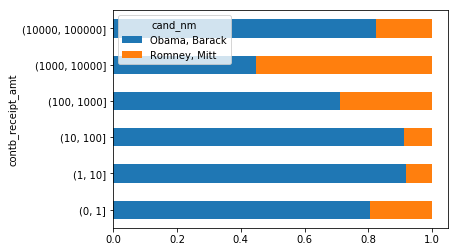

In [62]:
normed_sums[:-2].plot(kind='barh', stacked=True)

## Donation statistics by state

In [63]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [64]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
